In [1]:
# Import des libraries
import sys
sys.path.insert(0, '../src/')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import shap
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


import xgboost as xgb 

# Importing libraries - sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle       # for saving/loading train-test sets

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import auto_co2 as co2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

2024-01-14 22:02:59.941421: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 22:02:59.957743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **0. Introduction**


In [2]:
%%time
# Import des données: le dataset entier a pour chemin d'accès: data/processed/co2_classification_xx...
file_path = "../data/sample/co2_regression_sample.csv"
df = pd.read_csv(file_path)

target = df['Co2EmissionsWltp']
data = df.drop(columns='Co2EmissionsWltp')
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.3, random_state=100)

scaler = preprocessing.StandardScaler()
X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

CPU times: user 10.7 ms, sys: 1.27 ms, total: 11.9 ms
Wall time: 11.3 ms


In [3]:
co2.styles.display_info(df)
co2.styles.displayer(data)
co2.styles.displayer(pd.DataFrame(target))

co2.viz.plot_continuous_distribution(target)

,Column,Non-Null Count,Dtype
0,MassRunningOrder,4749 non-null,float64
1,Co2EmissionsWltp,4749 non-null,float64
2,BaseWheel,4749 non-null,float64
3,EnginePower,4749 non-null,float64
4,InnovativeTechnology,4749 non-null,int64
5,ElectricRange,4749 non-null,float64
6,Pool_BMW,4749 non-null,int64
7,Pool_FORD,4749 non-null,int64
8,Pool_HYUNDAI,4749 non-null,int64
9,Pool_KIA,4749 non-null,int64


<class 'pandas.io.formats.style.Styler'>


,Info
0,"RangeIndex: 4749 entries, 0 to 4748"
1,Data columns (total 25 columns):
2,24 FuelType_PETROL/ELECTRIC 4749 non-null int64
3,"dtypes: float64(5), int64(20)"
4,memory usage: 927.7 KB


<class 'pandas.io.formats.style.Styler'>


,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElectricRange,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_VW-SAIC,FuelType_DIESEL,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC
0,1615.000,2829.000,128.000,1,0.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,1313.000,2667.000,81.000,1,0.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1475.000,2612.000,70.000,0,0.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,1601.000,2629.000,110.000,1,0.000,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,1248.000,2417.000,61.000,0,0.000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


<class 'pandas.io.formats.style.Styler'>


,Co2EmissionsWltp
0,134.000
1,120.000
2,126.000
3,148.000
4,0.000


<class 'pandas.io.formats.style.Styler'>


# **1. Régression Linéaire**

In [4]:
# model configuration ant training
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

pred = lr1.predict(X_train)
pred_test = lr1.predict(X_test)


co2.styles.display_combined_report(y_train, pred, y_test, pred_test, title='PERFORMANCES DU MODELE DE REGRESSION LINEAIRE')
co2.styles.displayer(pd.DataFrame({'Co2 Observé': y_test, 'Co2 prédit': pred_test},
             index=X_test.index), n=10, title='REGRESSION LINEAIRE: COMPARAISON DE QUELQUES VALEURS')

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "Régression linéaire simple", interactive=True, save=True, format='png')

,Train Set,Test Set
Mean Squared Error,302.152,317.510
Root Mean Squared Error,17.383,17.819
Mean Absolute Error,11.379,11.289
R2 Score,0.887,0.879


<class 'pandas.io.formats.style.Styler'>


,Co2 Observé,Co2 prédit
591,111.000,122.835
2462,133.000,139.710
1323,116.000,126.210
3768,125.000,131.960
3632,118.000,124.897
1828,29.000,38.835
3464,182.000,162.272
2610,143.000,144.522
10,129.000,126.835
2590,115.000,123.897


<class 'pandas.io.formats.style.Styler'>


# **2. Modèle ElasticNet**

In [5]:
%%time
l1_ratios = [0.05, 0.1, 0.2, 0.5, 0.6, 1]
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratios, alphas=[0.1, 0.5, 0.9, 0.95, 1.0], n_jobs=-1)
lr_en.fit(X_train, y_train)


co2.styles.display_combined_report(y_train, lr_en.predict(X_train), y_test, lr_en.predict(X_test), title='PERFORMANCES DU MODELE ELASTIC NET') 

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "ElasticNet", interactive=True, save=True, format='png')
co2.viz.plot_lr_elasticnet(lr_en, save=True, format='png')
co2.viz.plot_mse_folds(lr_en, l1_ratios)


co2.data.save_model(lr_en)

,Train Set,Test Set
Mean Squared Error,302.339,317.274
Root Mean Squared Error,17.388,17.812
Mean Absolute Error,11.404,11.295
R2 Score,0.887,0.879


<class 'pandas.io.formats.style.Styler'>


Model saved at ../models/ElasticNetCV_20240114_220302.pkl
CPU times: user 372 ms, sys: 1.24 s, total: 1.61 s
Wall time: 408 ms


# **3. Modèle d'ensemble XGBoost Regressor**

In [6]:
%%time

X_temp, X_test, y_temp, y_test = train_test_split(data, target, test_size = 0.2, random_state = 2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 3)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 10, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

pred_test = model.predict(test)
pred_train = model.predict(train)


co2.styles.display_combined_report(y_train, pred_train, y_test, pred_test, title='PERFORMANCES DU MODELE XGBOOST') 

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "Régression linéaire simple", interactive=True, save=True, format='png')

co2.data.save_model(model, 'xgb') 

[0]	train-rmse:13.61149	valid-rmse:16.87196
[1]	train-rmse:10.80115	valid-rmse:15.12267
[2]	train-rmse:9.86664	valid-rmse:14.64305
[3]	train-rmse:9.01815	valid-rmse:14.07552
[4]	train-rmse:8.44417	valid-rmse:13.85649
[5]	train-rmse:7.99872	valid-rmse:13.88293
[6]	train-rmse:7.10773	valid-rmse:13.78352
[7]	train-rmse:6.96698	valid-rmse:13.71676
[8]	train-rmse:6.61622	valid-rmse:13.53337
[9]	train-rmse:6.38401	valid-rmse:13.83098


/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[22:03:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



,Train Set,Test Set
Mean Squared Error,40.756,191.296
Root Mean Squared Error,6.384,13.831
Mean Absolute Error,3.846,5.950
R2 Score,0.985,0.928


<class 'pandas.io.formats.style.Styler'>


Model saved at ../models/Booster_20240114_220302.pkl
CPU times: user 1.03 s, sys: 66.1 ms, total: 1.09 s
Wall time: 311 ms


# **4. Interprétabilité du modèle XGB Linear Regressor**

[24/24] features ████████████████████ Time elapsed: 0 seconds

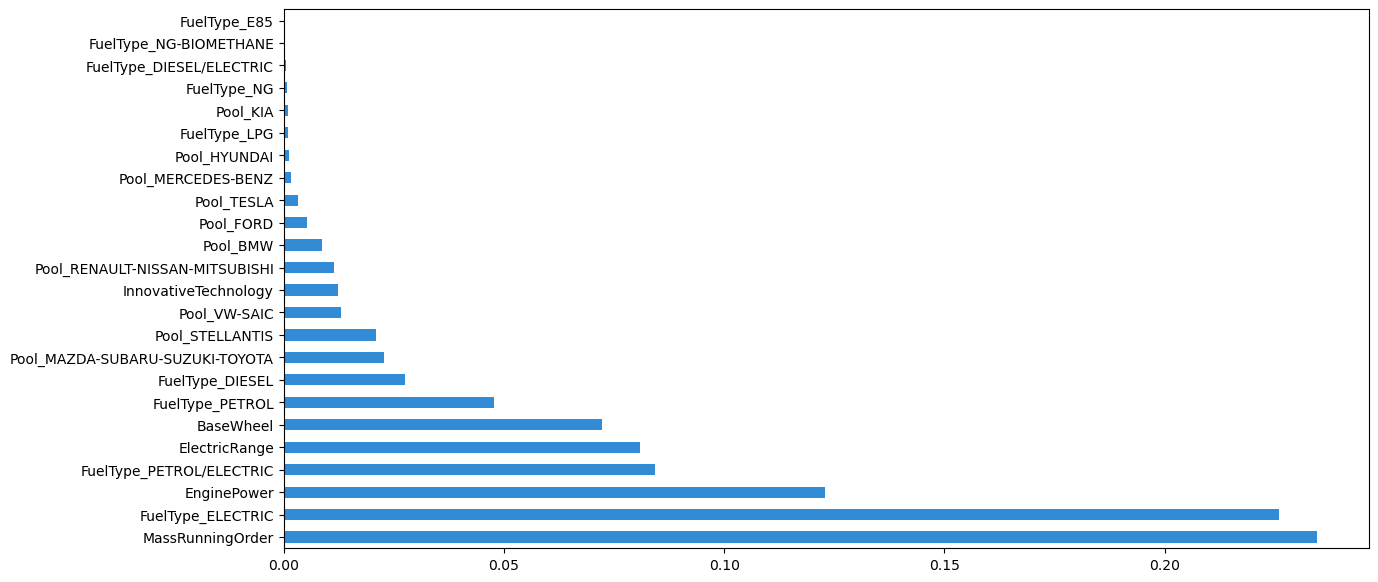

In [7]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.model import InMemoryModel

# Define a prediction function for the model
def predict_xg(x):
    return pd.DataFrame(model.predict(xgb.DMatrix(x)))

# Create an in-memory model
model_1 = InMemoryModel(predict_xg, examples = X_train)

# Create an interpreter
interpreter = Interpretation(X_train, feature_names=X_train.columns)

# Set the figure size for the plot
plt.rcParams['figure.figsize'] = (14,7)

# Generate a feature importance plot
plots = interpreter.feature_importance.plot_feature_importance(model_1, ascending=True)

/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[22:03:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



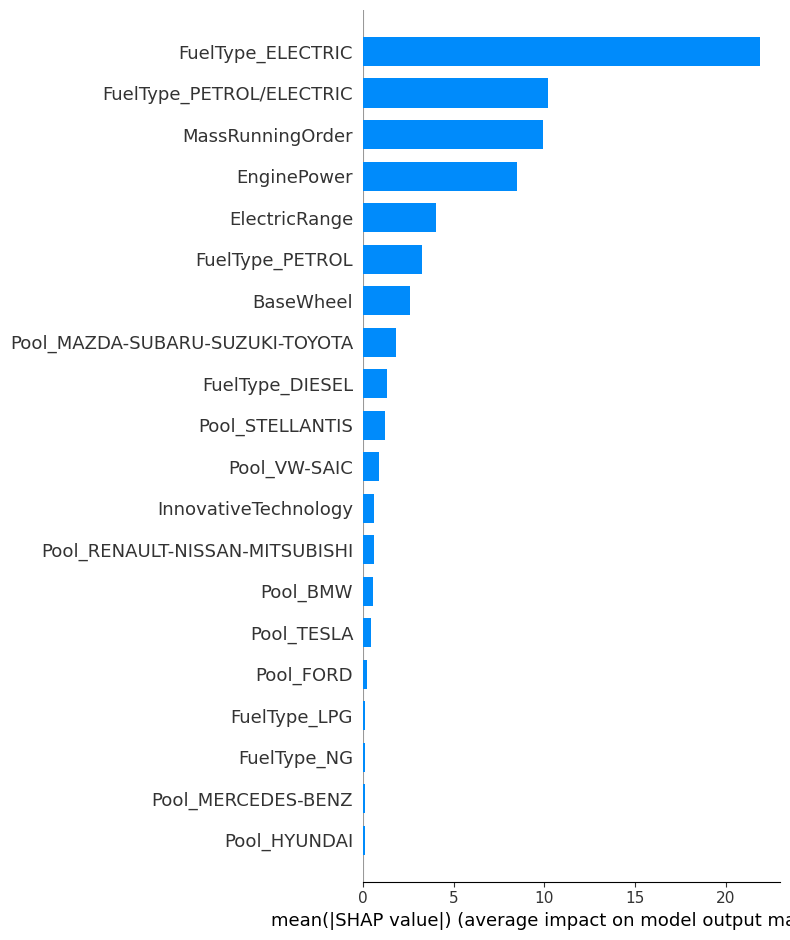

SHAP values saved at ../output/interpretability/ndarray_shap_values_20240114_220303.csv
Explainer information saved at ../output/interpretability/ndarray_explainer_20240114_220303.csv


In [8]:

# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a SHAP explanation object
shap_explanation = shap.Explanation(values=shap_values, data=X_train, feature_names=X_train.columns)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Generate SHAP dependence plots
co2.viz.plot_shap_dependence("ElectricRange", "MassRunningOrder", shap_values, X_test)
co2.viz.plot_shap_dependence("MassRunningOrder", "EnginePower", shap_values, X_test)

# Visualize the first tree from the model
xgb.to_graphviz(model, num_trees=0)

co2.data.save_shap_values(shap_values, X_test)

In [9]:
# Récupération des prédictions

# pred_test = model.predict(test)
# pred_train = model.predict(train)

#Entraînement du modèle
sg_clf = LinearRegression()
sg_clf.fit(X_train, pred_train)

# Scores du modèle
sg_clf.score(X_test, y_test)
# print(classification_report(y_test, sg_clf.predict(X_test)))

# #Comparaison des prédictions
# print(sum(preds!=sg_clf.predict(X_train)))

# # Comparaison des prédictions sur le jeu de test
# probs = bst.predict(dtest)
# preds = [0 if x<0.5 else 1 for x in probs]

0.8769934526561693